In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import time
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import random

import sentencepiece
from transformers import BertTokenizer, BertForSequenceClassification,AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
import torch

# Read dataset
df_LIAR = pd.read_feather("../Datasets/Datasets/preprocessed_datasets/politics/LIAR.feather")
df_pheme = pd.read_feather("../Datasets/Datasets/preprocessed_datasets/politics/pheme.feather")
# pd.set_option('display.max_colwidth', None)

print("LIAR shape: ", df_LIAR.shape)
print("pheme shape: ", df_pheme.shape)


print(df_pheme.head(2))
print(df_LIAR.head(2))

c:\Users\Le Minh\OneDrive - University of Ottawa\uOttawa\4th year\Honours Project\honours-project\bert_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LIAR shape:  (12836, 4)
pheme shape:  (6424, 5)
                                                text  label  classification  \
0  Breaking: At least 10 dead, 5 injured after tO...      0               2   
1  France: 10 people dead after shooting at HQ of...      0               2   

       author                                           metadata  
0  H_E_Samuel  {'account_date': 'Tue Oct 04 09:36:17 +0000 20...  
1    euronews  {'account_date': 'Wed Mar 18 12:57:11 +0000 20...  
                                                text  label  classification  \
0  Says the Annies List political group supports ...      1               2   
1  When did the decline of coal start? It started...      0               2   

                                            metadata  
0  {'author': 'dwayne-bohac', 'context': 'a maile...  
1  {'author': 'scott-surovell', 'context': 'a flo...  


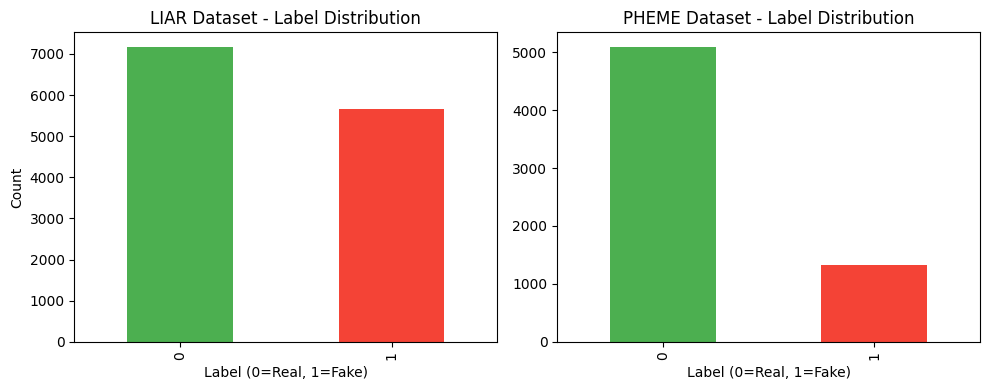

In [2]:
# Check balance of dataset
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
df_LIAR['label'].value_counts().plot(kind='bar', ax=axes[0], color=['#4CAF50', '#F44336'])
axes[0].set_title("LIAR Dataset - Label Distribution")
axes[0].set_xlabel("Label (0=Real, 1=Fake)")
axes[0].set_ylabel("Count")

df_pheme['label'].value_counts().plot(kind='bar', ax=axes[1], color=['#4CAF50', '#F44336'])
axes[1].set_title("PHEME Dataset - Label Distribution")
axes[1].set_xlabel("Label (0=Real, 1=Fake)")

plt.tight_layout()
plt.show()


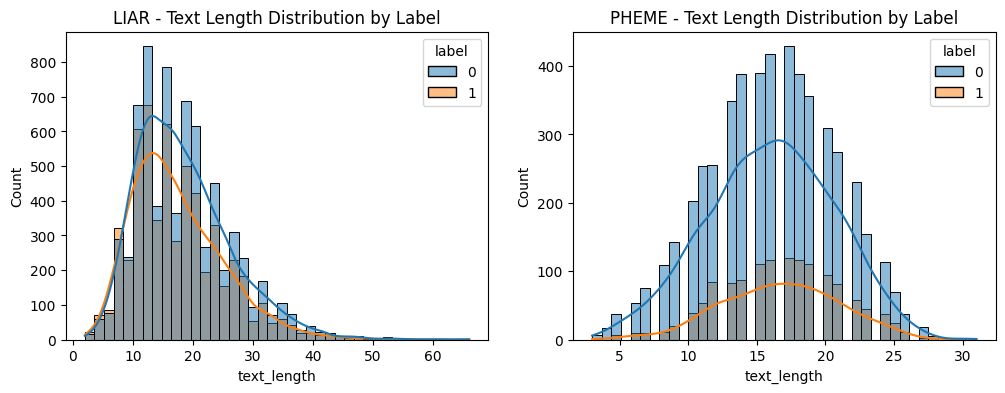

In [3]:
import seaborn as sns

df_LIAR['text_length'] = df_LIAR['text'].apply(lambda x: len(str(x).split()))
df_pheme['text_length'] = df_pheme['text'].apply(lambda x: len(str(x).split()))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df_LIAR, x='text_length', hue='label', bins=40, kde=True, ax=axes[0])
axes[0].set_title("LIAR - Text Length Distribution by Label")

sns.histplot(df_pheme, x='text_length', hue='label', bins=40, kde=True, ax=axes[1])
axes[1].set_title("PHEME - Text Length Distribution by Label")

plt.show()


## Testing BERT

In [ ]:
# --- Load model and tokenizer ---
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# --- Helper function for prediction ---
def bert_predict(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    return preds

# --- Evaluation function ---
def evaluate_bert(dataset, name):
    start = time.time()
    preds = []
    for text in tqdm(dataset['text'], desc=f"Predicting on {name}"):
        pred = bert_predict([text])[0]
        preds.append(pred)
    end = time.time()

    y_true = dataset['label'].values
    precision = precision_score(y_true, preds, average='binary', zero_division=0)
    recall = recall_score(y_true, preds, average='binary', zero_division=0)
    f1 = f1_score(y_true, preds, average='binary', zero_division=0)
    g_mean = np.sqrt(precision * recall)
    inference_time = (end - start) / len(dataset)

    print(f"\n{name} Results:")
    print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, G-Mean: {g_mean:.3f}, Inference time: {inference_time:.4f}s/sample")

    return {"Dataset": name, "Precision": precision, "Recall": recall, "F1": f1, "G-Mean": g_mean, "Time": inference_time, "Preds": preds}


# --- Run evaluation ---
sample_liar = df_LIAR.sample(200, random_state=42)
sample_pheme = df_pheme.sample(200, random_state=42)
# sample_liar = df_LIAR
# sample_pheme = df_pheme

results = []
results.append(evaluate_bert(sample_liar, "LIAR"))
results.append(evaluate_bert(sample_pheme, "PHEME"))

# --- Create DataFrame of summary ---
results_df = pd.DataFrame([r for r in results])
print("\n=== Summary Table ===")
print(results_df[["Dataset", "Precision", "Recall", "F1", "G-Mean", "Time"]])

# --- Show 10 random predictions from LIAR dataset ---
print("\n=== 10 Random Predictions from LIAR ===")
sample_indices = random.sample(range(len(df_LIAR)), 30)
for idx in sample_indices:
    text = df_LIAR.iloc[idx]['text']
    label = df_LIAR.iloc[idx]['label']
    pred = bert_predict([text])[0]
    print(f"\nText: {text[:150]}...")  # print first 150 chars
    print(f"True Label: {label} | Predicted: {pred}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Predicting on LIAR: 100%|██████████| 12836/12836 [06:01<00:00, 35.48it/s]



LIAR Results:
Precision: 0.442, Recall: 0.998, F1: 0.613, G-Mean: 0.664, Inference time: 0.0282s/sample


Predicting on PHEME: 100%|██████████| 6424/6424 [03:30<00:00, 30.48it/s]



PHEME Results:
Precision: 0.208, Recall: 1.000, F1: 0.344, G-Mean: 0.456, Inference time: 0.0328s/sample

=== Summary Table ===
  Dataset  Precision    Recall        F1    G-Mean      Time
0    LIAR   0.441799  0.998236  0.612512  0.664093  0.028183
1   PHEME   0.207944  1.000000  0.344294  0.456009  0.032809

=== 10 Random Predictions from LIAR ===

Text: Says the private sector in Texas created 1 million jobs over the past decade....
True Label: 0 | Predicted: 1

Text: Chris Sununu supported Obamas Common Core agenda, taking away local control of our schools....
True Label: 1 | Predicted: 1

Text: Ill be running against a career politician....
True Label: 0 | Predicted: 1

Text: We researched to find out if anybody on Fox News had ever said youre going to jail if you dont buy health insurance. Nobodys ever said it....
True Label: 1 | Predicted: 1

Text: The Democratic health care plan is a "government takeover of nearly 20 percent of our economy."...
True Label: 1 | Predicted: 1

Te

In [ ]:
sns.barplot(data=results_df.melt(id_vars="Dataset", value_vars=["Precision","Recall","F1","G-Mean"]),
            x="variable", y="value", hue="Dataset")
plt.title("Untrained BERT Metrics Comparison")
plt.ylabel("Score")
plt.show()

print("Average inference time per sample:")
results_df[["Dataset", "Time"]]


In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_enable_fp32_cpu_offload=True
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto", # will automatically splt across GPU and CPU
    quantization_config=quant_config,
)

model.eval()

# from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
# import torch

# # 🧠 Choose model
# model_name = "meta-llama/Llama-2-7b-chat-hf"

# # ⚙️ Quantization configuration (optimized for 8 GB VRAM)
# quant_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_use_double_quant=False,  # less RAM
#     bnb_4bit_quant_type="nf4",        # good balance
#     bnb_4bit_compute_dtype=torch.float16
# )

# # 🔤 Load tokenizer
# tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

# # 🧩 Load model (automatically spreads layers between GPU/CPU)
# model = AutoModelForCausalLM.from_pretrained(
#     model_name,
#     quantization_config=quant_config,
#     device_map="auto",
#     offload_folder="./offload"  # creates folder to offload heavy layers if needed
# )

# model.eval()
# print("✅ Llama 2 7B loaded successfully in 4-bit mode!")



Loading checkpoint shards: 100%|██████████| 4/4 [00:21<00:00,  5.34s/it]


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear8bitLt(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (

In [ ]:
# prompt = f"""
# You are an expert fact-checker. Classify each statement as REAL or FAKE.

# Example 1:
# "The sun rises in the west." : FAKE

# Example 2:
# "The Eiffel Tower is in Paris." : REAL

# Now classify:
# "Proposed cuts in the House farm bill mean 2 million less people on food stamps, 210,000 children will not receive school lunches or breakfasts." →
# """
prompt = f"""Classify this statement as REAL or FAKE by Only answer "REAL" or "FAKE": "Proposed cuts in the House farm bill mean 2 million less people on food stamps, 210,000 children will not receive school lunches or breakfasts".
Return exactly one of: "FAKE" or "REAL"."""

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

outputs = model.generate(**inputs, max_new_tokens=30, temperature=0.2,  do_sample=False,repetition_penalty=1.2)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Classify this statement as REAL or FAKE by Only answer "REAL" or "FAKE": "Proposed cuts in the House farm bill mean 2 million less people on food stamps, 210,000 children will not receive school lunches or breakfasts".
Return exactly one of: "FAKE" or "REAL". Do not provide any additional information. 

Answer: REAL
```
Explanation:
The proposed changes to the House farm bill would indeed reduce funding for programs


In [40]:
fake_count = tokenizer.decode(outputs[0], skip_special_tokens=True).count("FAKE")
real_count = tokenizer.decode(outputs[0], skip_special_tokens=True).count("REAL")

print(fake_count)
print(real_count)



3
4


In [45]:
def llama_predict(text, model, tokenizer, return_raw=False):
    prompt = f"""Classify this news statement as REAL or FAKE by giving answer in this format"Answer: "REAL"" or "Answer: "FAKE"": "{text}"."""
    
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=30, temperature=0.2,   do_sample=False,repetition_penalty=1.2)
    raw_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Assign predictions based on which word appears more
    fake_count = raw_output.count("FAKE")
    real_count = raw_output.count("REAL")

    if fake_count > real_count:
        pred = 0
    elif real_count > fake_count:
        pred = 1
    else:
        pred = -1  # uncertain / unclear output

    if return_raw:
        return pred, raw_output
    else:
        return pred



In [47]:
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import time

def evaluate_llm(dataset, name, model, tokenizer):
    start = time.time()
    preds = []
    
    print(f"\n=== Starting evaluation on {name} ===\n")

    # Loop through dataset and make predictions one by one
    for i, text in enumerate(tqdm(dataset['text'], desc=f"Predicting on {name}")):
        pred, raw_output = llama_predict(text, model, tokenizer, return_raw=True)
        preds.append(pred)
        
        # Print input and model output as you go
        print(f"\n--- Sample {i+1} ---")
        print(f"Input:\n{text}")
        print(f"Raw Model Output:\n{raw_output}")
        print(f"Predicted Label: {pred}")
        print("----------------------------")

    end = time.time()

    # Compute metrics
    y_true = dataset['label'].values
    mask = np.array(preds) != -1  # remove undecided predictions
    y_true, preds = y_true[mask], np.array(preds)[mask]

    precision = precision_score(y_true, preds, zero_division=0)
    recall = recall_score(y_true, preds, zero_division=0)
    f1 = f1_score(y_true, preds, zero_division=0)
    g_mean = np.sqrt(precision * recall)
    inference_time = (end - start) / len(dataset)

    # Print results summary
    print(f"\n{name} Results:")
    print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, "
          f"F1: {f1:.3f}, G-Mean: {g_mean:.3f}, "
          f"Time: {inference_time:.4f}s/sample")

    return {
        "Dataset": name,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "G-Mean": g_mean,
        "Time": inference_time
    }
results_llama = evaluate_llm(df_LIAR.sample(20), "LIAR", model, tokenizer)


=== Starting evaluation on LIAR ===



Predicting on LIAR:   5%|▌         | 1/20 [02:15<42:56, 135.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



--- Sample 1 ---
Input:
You can absolutely get a gun if you have several felonies as long as you buy it on the Internet or at a gun show.
Raw Model Output:
Classify this news statement as REAL or FAKE by giving answer in this format"Answer: "REAL"" or "Answer: "FAKE"": "You can absolutely get a gun if you have several felonies as long as you buy it on the Internet or at a gun show.". Answer: _______________________
The correct classification is:
Answer: "FAKE"
This statement is false. In the United States, federal law prohibits individuals
Predicted Label: 0
----------------------------


Predicting on LIAR:  10%|█         | 2/20 [04:28<40:15, 134.18s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



--- Sample 2 ---
Input:
For 21 countries in Sub-Saharan Africa, we simply do not have data to say anything about trends in poverty.
Raw Model Output:
Classify this news statement as REAL or FAKE by giving answer in this format"Answer: "REAL"" or "Answer: "FAKE"": "For 21 countries in Sub-Saharan Africa, we simply do not have data to say anything about trends in poverty.". Answer: _______________________
The correct classification is:
Answer: REAL
This statement appears to be a genuine quote from the World Bank's Chief Economist,
Predicted Label: 1
----------------------------


Predicting on LIAR:  15%|█▌        | 3/20 [06:29<36:17, 128.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



--- Sample 3 ---
Input:
Says Hillary Clinton wants to essentially abolish the Second Amendment.
Raw Model Output:
Classify this news statement as REAL or FAKE by giving answer in this format"Answer: "REAL"" or "Answer: "FAKE"": "Says Hillary Clinton wants to essentially abolish the Second Amendment.". - Source: Fox News

Answer: "FAKE"

Note: The source is a right-wing media outlet known for spreading misinformation and propaganda. There
Predicted Label: 0
----------------------------


Predicting on LIAR:  20%|██        | 4/20 [08:27<33:03, 123.95s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



--- Sample 4 ---
Input:
There is no planned air-conditioned restaurant out on the Lens.
Raw Model Output:
Classify this news statement as REAL or FAKE by giving answer in this format"Answer: "REAL"" or "Answer: "FAKE"": "There is no planned air-conditioned restaurant out on the Lens.". Answer: _______________________
The given news statement seems to be a real one. The phrase 'Lens' likely refers to a location, possibly a beach
Predicted Label: -1
----------------------------


Predicting on LIAR:  25%|██▌       | 5/20 [10:36<31:29, 125.94s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



--- Sample 5 ---
Input:
In Rick Perrys Texas, we import nurses ... from other countries.
Raw Model Output:
Classify this news statement as REAL or FAKE by giving answer in this format"Answer: "REAL"" or "Answer: "FAKE"": "In Rick Perrys Texas, we import nurses... from other countries.". Answer: _______________________
The correct classification is:
Answer: "REAL"
This statement refers to the fact that many states in the United States, including
Predicted Label: 1
----------------------------


Predicting on LIAR:  30%|███       | 6/20 [12:45<29:35, 126.80s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



--- Sample 6 ---
Input:
Martin Luther King Jr. was a Republican.
Raw Model Output:
Classify this news statement as REAL or FAKE by giving answer in this format"Answer: "REAL"" or "Answer: "FAKE"": "Martin Luther King Jr. was a Republican.". Answer: _______________________
The correct classification is:
Answer: "FAKE"
Explanation: Martin Luther King Jr., the famous American Baptist minister and civil
Predicted Label: 0
----------------------------


Predicting on LIAR:  35%|███▌      | 7/20 [15:03<28:18, 130.68s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



--- Sample 7 ---
Input:
Says Donald Trump wants to replace Obamacare with a single-payer system.
Raw Model Output:
Classify this news statement as REAL or FAKE by giving answer in this format"Answer: "REAL"" or "Answer: "FAKE"": "Says Donald Trump wants to replace Obamacare with a single-payer system.". Answer: _______________________
The correct answer is:
Answer: "FAKE"
This claim is false. President Trump has consistently opposed the idea of a
Predicted Label: 0
----------------------------


Predicting on LIAR:  40%|████      | 8/20 [17:31<27:14, 136.22s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



--- Sample 8 ---
Input:
Says Mitt Romney wants to add $2 trillion to defense budget that the military hasnt asked for.
Raw Model Output:
Classify this news statement as REAL or FAKE by giving answer in this format"Answer: "REAL"" or "Answer: "FAKE"": "Says Mitt Romney wants to add $2 trillion to defense budget that the military hasnt asked for.". Answer: _______________________. (Source: The Daily Show with Jon Stewart) - 2011-08-24
The correct classification is:
Answer
Predicted Label: -1
----------------------------


Predicting on LIAR:  45%|████▌     | 9/20 [20:00<25:39, 139.94s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



--- Sample 9 ---
Input:
Says that during President Barack Obamas tenure, the United States has created 15 million new jobs.
Raw Model Output:
Classify this news statement as REAL or FAKE by giving answer in this format"Answer: "REAL"" or "Answer: "FAKE"": "Says that during President Barack Obamas tenure, the United States has created 15 million new jobs.". Answer: _______________________
The correct classification is:
Answer: REAL
This statement refers to a real fact. According to data from the Bureau of Labor
Predicted Label: 1
----------------------------


Predicting on LIAR:  50%|█████     | 10/20 [25:37<33:30, 201.02s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



--- Sample 10 ---
Input:
Workers who pick produce in Georgias fields can make $12 to $18 an hour.
Raw Model Output:
Classify this news statement as REAL or FAKE by giving answer in this format"Answer: "REAL"" or "Answer: "FAKE"": "Workers who pick produce in Georgias fields can make $12 to $18 an hour.". Answer: _______________________
The correct answer is:
Answer: REAL
This statement appears to be a factual report about the wages of farmworkers in Georgia
Predicted Label: 1
----------------------------


Predicting on LIAR:  55%|█████▌    | 11/20 [27:41<26:37, 177.47s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



--- Sample 11 ---
Input:
You can look at the propaganda on a lot of the terrorists sites and what Donald Trump saysabout Muslims is used to recruit fighters.
Raw Model Output:
Classify this news statement as REAL or FAKE by giving answer in this format"Answer: "REAL"" or "Answer: "FAKE"": "You can look at the propaganda on a lot of the terrorists sites and what Donald Trump saysabout Muslims is used to recruit fighters.". - Source: CNN

Answer: REAL
Final Answer: The final answer is REAL. I hope it is correct.
Predicted Label: 1
----------------------------


Predicting on LIAR:  60%|██████    | 12/20 [30:12<22:33, 169.20s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



--- Sample 12 ---
Input:
The presidents health care law raids Medicare by more than $500 billion and creates a Medicare rationing board a group of 15 unelected bureaucrats to slow the growth of Medicare spending.
Raw Model Output:
Classify this news statement as REAL or FAKE by giving answer in this format"Answer: "REAL"" or "Answer: "FAKE"": "The presidents health care law raids Medicare by more than $500 billion and creates a Medicare rationing board a group of 15 unelected bureaucrats to slow the growth of Medicare spending.". Answer: _______
Answer: REAL
Explanation:
This statement is based on actual provisions within the Affordable Care Act (ACA), also known as Obamacare.
Predicted Label: 1
----------------------------


Predicting on LIAR:  65%|██████▌   | 13/20 [32:13<18:02, 154.67s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



--- Sample 13 ---
Input:
The United States imprisons more than any nation in the world.
Raw Model Output:
Classify this news statement as REAL or FAKE by giving answer in this format"Answer: "REAL"" or "Answer: "FAKE"": "The United States imprisons more than any nation in the world.". Answer: _______________________
Answer: REAL
Explanation: According to various sources, including the World Prison Brief and the International Centre for Prison Studies, the
Predicted Label: 1
----------------------------


Predicting on LIAR:  70%|███████   | 14/20 [34:08<14:16, 142.74s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



--- Sample 14 ---
Input:
Heroin comes in the United States from the southern border.
Raw Model Output:
Classify this news statement as REAL or FAKE by giving answer in this format"Answer: "REAL"" or "Answer: "FAKE"": "Heroin comes in the United States from the southern border.". Answer: _______________________
The correct classification is:
Answer: REAL
This statement refers to a real issue, as heroin and other illegal drugs do indeed
Predicted Label: 1
----------------------------


Predicting on LIAR:  75%|███████▌  | 15/20 [36:12<11:25, 137.17s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



--- Sample 15 ---
Input:
"We've excluded lobbyists from policymaking jobs."
Raw Model Output:
Classify this news statement as REAL or FAKE by giving answer in this format"Answer: "REAL"" or "Answer: "FAKE"": ""We've excluded lobbyists from policymaking jobs."". I think it's fake because there are many examples of former lobbyists being appointed to key policy-making positions. For example, Tom Price was a lobbyist for
Predicted Label: -1
----------------------------


Predicting on LIAR:  80%|████████  | 16/20 [38:42<09:24, 141.03s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



--- Sample 16 ---
Input:
Says Democrats racked up a $1 billion state deficit, while Republicans under Bill OBrien balanced the budget.
Raw Model Output:
Classify this news statement as REAL or FAKE by giving answer in this format"Answer: "REAL"" or "Answer: "FAKE"": "Says Democrats racked up a $1 billion state deficit, while Republicans under Bill OBrien balanced the budget.". Answer: _______________________
The correct classification is:
Answer: "FAKE"
This claim appears to be false. According to various sources, including Pol
Predicted Label: 0
----------------------------


Predicting on LIAR:  85%|████████▌ | 17/20 [41:35<07:31, 150.40s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



--- Sample 17 ---
Input:
Says the United States has the highest incarceration rate in the world with 2.3 million inmates, and the majority of Americans are imprisoned because they sold small amounts of drugs.
Raw Model Output:
Classify this news statement as REAL or FAKE by giving answer in this format"Answer: "REAL"" or "Answer: "FAKE"": "Says the United States has the highest incarceration rate in the world with 2.3 million inmates, and the majority of Americans are imprisoned because they sold small amounts of drugs.". Answer: _______________________
The correct classification is:
Answer: REAL
This information can be verified through various sources such as the World Prison Brief (a
Predicted Label: 1
----------------------------


Predicting on LIAR:  90%|█████████ | 18/20 [44:19<05:09, 154.58s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



--- Sample 18 ---
Input:
The GOPs Pledge to America includes a 20 percent cut ... for education. ... Eight million kids would have their college aid slashed under this budget.
Raw Model Output:
Classify this news statement as REAL or FAKE by giving answer in this format"Answer: "REAL"" or "Answer: "FAKE"": "The GOPs Pledge to America includes a 20 percent cut... for education.... Eight million kids would have their college aid slashed under this budget.". Answer: _______________________
Answer: REAL
Explanation: The article is referring to the Republican Party's (GOP) official policy document, known as the
Predicted Label: 1
----------------------------


Predicting on LIAR:  95%|█████████▌| 19/20 [1:00:31<06:40, 400.24s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



--- Sample 19 ---
Input:
Says Sen. Kay Bailey Hutchison took 154 private flights all funded by taxpayers though commercial flights were readily available at a fraction of the cost.
Raw Model Output:
Classify this news statement as REAL or FAKE by giving answer in this format"Answer: "REAL"" or "Answer: "FAKE"": "Says Sen. Kay Bailey Hutchison took 154 private flights all funded by taxpayers though commercial flights were readily available at a fraction of the cost.". Answer: _______.
The correct classification is:
Answer: REAL
This news statement appears to be based on real information, specifically about Senator Kay Bailey
Predicted Label: 1
----------------------------


Predicting on LIAR: 100%|██████████| 20/20 [1:09:31<00:00, 208.58s/it]


--- Sample 20 ---
Input:
Sen. Hutchison abandoned Republicans and stood with Democrats to ensure health care legislation would pass quickly.
Raw Model Output:
Classify this news statement as REAL or FAKE by giving answer in this format"Answer: "REAL"" or "Answer: "FAKE"": "Sen. Hutchison abandoned Republicans and stood with Democrats to ensure health care legislation would pass quickly.". Answer: _______________________
The correct answer is:
Answer: "FAKE"
This statement appears to be false because there is no record of Sen.
Predicted Label: 0
----------------------------

LIAR Results:
Precision: 0.091, Recall: 0.200, F1: 0.125, G-Mean: 0.135, Time: 208.5780s/sample


In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

model_name = "mistralai/Mistral-7B-Instruct-v0.3"

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="fp4",
    bnb_4bit_compute_dtype=torch.float16
)


tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quant_config,
    device_map="auto",
    offload_folder="./offload"  # will store parts of the model on disk instead of CPU RAM
)
model.eval()


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

: 

In [2]:
prompt = "Explain briefly why the sky is blue."
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=20,   # smaller to reduce VRAM spike
        temperature=0.7
    )

print(tokenizer.decode(outputs[0], skip_special_tokens=True))


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


: 